In [1]:
pip install pandas numpy scikit-learn matplotlib seaborn scipy


In [2]:
import pandas as pd

In [14]:
df = pd.read_excel("C:/Users/sreej/OneDrive/Desktop/cibc.xlsx")


In [13]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [15]:
df.head()

,Client ID,Survey Response Date,Survey Response Channel,NPS Score,Client First Service Date,Age,Gender,Province,High Value Client Indicator,Has Credit Card,Has Deposit Account,Has Investment Account,Has Borrowing Product,Total Product Count,Total Funds Managed,Chequing Balance,Savings Balance,Credit Card Balance,Client Attrited
0,939L4933M74330OZ,2024-02-25,Mobile,0,1985-01-17,51 to 65,F,ON,0,0,1,0,1,4,400.0,300.0,NaN,NaN,No
1,429I6439D19572YJ,2024-01-24,Online,9,1988-01-26,51 to 65,F,BC,0,1,1,1,1,7,82600.0,39700.0,200.0,0.0,No
2,920A8054B28169QO,2024-05-22,Online,9,2019-01-13,19 to 35,F,NS,0,1,1,0,0,3,15000.0,1300.0,0.0,12000.0,No
3,957H8335M34557RI,2023-12-08,Mobile,10,1998-01-03,36 to 50,F,ON,0,1,1,0,1,4,19000.0,1700.0,NaN,6500.0,No
4,490W8554J38739BQ,2024-07-29,Mobile,8,1987-01-08,81 to 85,M,NB,0,1,1,0,0,4,3500.0,1500.0,NaN,1000.0,No


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11044 entries, 0 to 11043
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Client ID                    11044 non-null  object        
 1   Survey Response Date         11044 non-null  datetime64[ns]
 2   Survey Response Channel      11044 non-null  object        
 3   NPS Score                    11044 non-null  int64         
 4   Client First Service Date    11044 non-null  datetime64[ns]
 5   Age                          11044 non-null  object        
 6   Gender                       11044 non-null  object        
 7   Province                     11041 non-null  object        
 8   High Value Client Indicator  11044 non-null  int64         
 9   Has Credit Card              11044 non-null  int64         
 10  Has Deposit Account          11044 non-null  int64         
 11  Has Investment Account       11044 non-nu

In [17]:
import numpy as np

# Convert date columns
df['Survey Response Date'] = pd.to_datetime(df['Survey Response Date'])
df['Client First Service Date'] = pd.to_datetime(df['Client First Service Date'])

# Create a new feature: Customer Tenure in Years
df['Customer Tenure'] = (df['Survey Response Date'] - df['Client First Service Date']).dt.days / 365

# Convert 'Client Attrited' to binary (Yes = 1, No = 0)
df['Client Attrited'] = df['Client Attrited'].map({'Yes': 1, 'No': 0})

# Handle missing numerical values (replace with median)
numerical_cols = ['Total Funds Managed', 'Chequing Balance', 'Savings Balance', 'Credit Card Balance']
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

# One-hot encode categorical columns (remove one to avoid multicollinearity)
df = pd.get_dummies(df, columns=['Survey Response Channel', 'Age', 'Gender', 'Province'], drop_first=True)

# Display dataset info after preprocessing
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11044 entries, 0 to 11043
Data columns (total 51 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Client ID                       11044 non-null  object        
 1   Survey Response Date            11044 non-null  datetime64[ns]
 2   NPS Score                       11044 non-null  int64         
 3   Client First Service Date       11044 non-null  datetime64[ns]
 4   High Value Client Indicator     11044 non-null  int64         
 5   Has Credit Card                 11044 non-null  int64         
 6   Has Deposit Account             11044 non-null  int64         
 7   Has Investment Account          11044 non-null  int64         
 8   Has Borrowing Product           11044 non-null  int64         
 9   Total Product Count             11044 non-null  int64         
 10  Total Funds Managed             11044 non-null  float64       
 11  Ch

In [18]:
from scipy.stats import ttest_ind

In [19]:
# --- 1. Calculate Estimated Customer Effort Score (CES) ---
# Normalize relevant features for CES calculation
df['CES_Estimate'] = (
    (df['Total Product Count'] / df['Total Product Count'].max()) * 3 +  # More products = lower effort
    (df['Total Funds Managed'] / df['Total Funds Managed'].max()) * 2 +  # Higher funds = lower effort
    (df['Has Borrowing Product'] * 1) +  # Borrowing may increase effort
    (df['Has Credit Card'] * 1)  # More accounts may indicate higher effort
)


In [20]:
# Scale CES to a 1-7 scale
df['CES_Estimate'] = 7 - (df['CES_Estimate'] / df['CES_Estimate'].max()) * 6


In [21]:
# --- 2. Calculate Customer Satisfaction Score (CSAT) ---
def nps_to_csat(nps):
    if nps >= 9:
        return np.random.uniform(80, 100)  # Promoters
    elif nps >= 7:
        return np.random.uniform(60, 79)   # Passives
    else:
        return np.random.uniform(0, 59)    # Detractors

df['CSAT_Score'] = df['NPS Score'].apply(nps_to_csat)


In [22]:
# --- 3. A/B Testing: High vs. Low Product Engagement ---
high_engagement = df[df['Total Product Count'] >= df['Total Product Count'].median()]['NPS Score']
low_engagement = df[df['Total Product Count'] < df['Total Product Count'].median()]['NPS Score']

# Perform independent t-test to compare means
t_stat, p_value = ttest_ind(high_engagement, low_engagement, equal_var=False)


In [23]:
# Display results
ces_summary = df[['NPS Score', 'CES_Estimate']].corr().iloc[0, 1]
csat_summary = df[['NPS Score', 'CSAT_Score']].corr().iloc[0, 1]

print("Correlation between CES & NPS:", ces_summary)
print("Correlation between CSAT & NPS:", csat_summary)
print("A/B Test - T-Statistic:", t_stat)
print("A/B Test - P-Value:", p_value)

Correlation between CES & NPS: -0.0653917667384722
Correlation between CSAT & NPS: 0.8544296201850615
A/B Test - T-Statistic: 5.953510841619261
A/B Test - P-Value: 2.709766534621598e-09


CES (Customer Effort Score) vs. NPS
Correlation: -0.065 (-6.5%) (Weak negative correlation)
This means lower effort (CES) does not strongly correlate with higher NPS.
Customers do not seem to rate NPS solely based on ease of service.
. CSAT (Customer Satisfaction Score) vs. NPS
Correlation: 0.85 (85%) (Strong positive correlation)
Higher NPS scores are highly linked to higher CSAT scores.
This confirms that NPS is a strong indicator of overall customer satisfaction.
 A/B Testing: Impact of Product Engagement on NPS
T-Statistic: 5.95 (Large effect)
P-Value: 2.7e-09 (Highly significant)
Customers with more banking products have significantly higher NPS scores.
Conclusion: Encouraging multi-product adoption increases customer loyalty and satisfaction.


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set_theme(style="whitegrid")

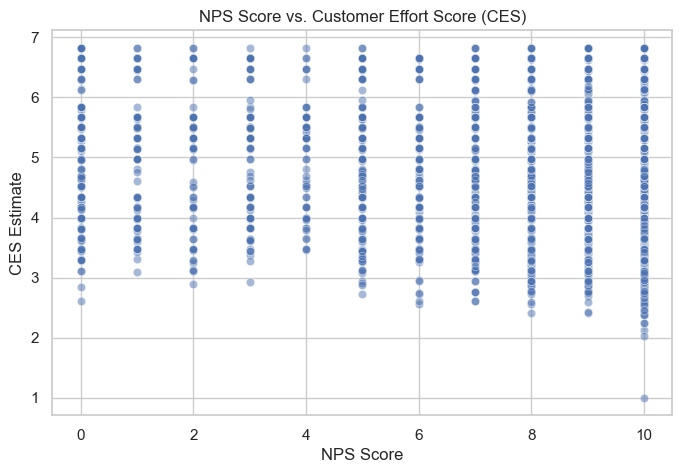

In [25]:
# --- 1. Scatter Plot: NPS vs. CES ---
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df['NPS Score'], y=df['CES_Estimate'], alpha=0.5)
plt.title("NPS Score vs. Customer Effort Score (CES)")
plt.xlabel("NPS Score")
plt.ylabel("CES Estimate")
plt.show()

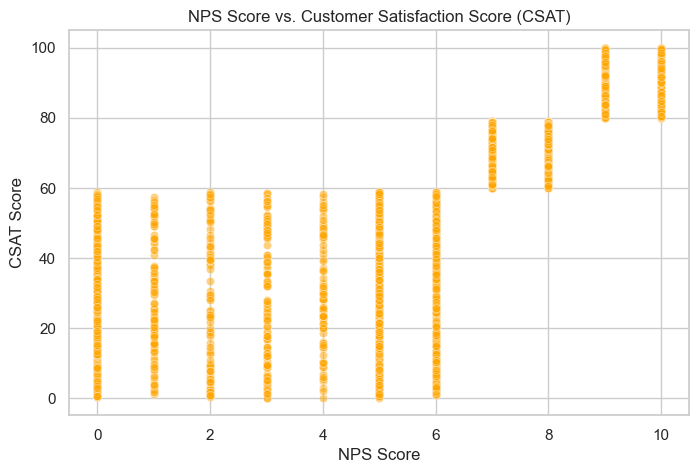

In [26]:
# --- 2. Scatter Plot: NPS vs. CSAT ---
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df['NPS Score'], y=df['CSAT_Score'], alpha=0.5, color="orange")
plt.title("NPS Score vs. Customer Satisfaction Score (CSAT)")
plt.xlabel("NPS Score")
plt.ylabel("CSAT Score")
plt.show()

C:\Users\sreej\AppData\Local\Temp\ipykernel_12052\4140505176.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=pd.cut(df['Total Product Count'], bins=[0, df['Total Product Count'].median(), df['Total Product Count'].max()], labels=["Low Engagement", "High Engagement"]),


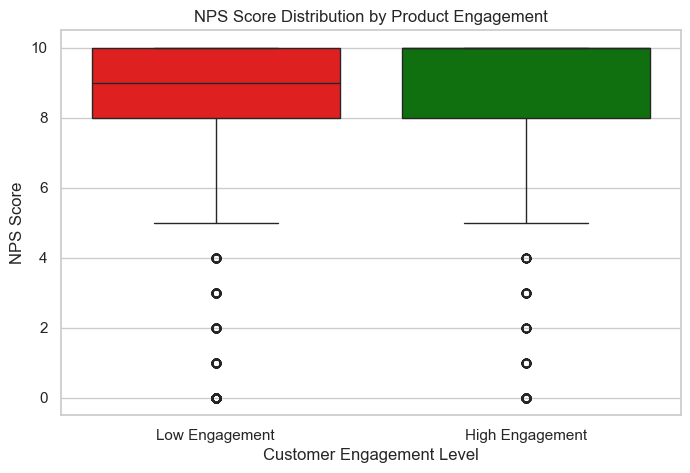

In [27]:
# --- 3. Box Plot: A/B Test (High vs. Low Engagement) ---
plt.figure(figsize=(8, 5))
sns.boxplot(x=pd.cut(df['Total Product Count'], bins=[0, df['Total Product Count'].median(), df['Total Product Count'].max()], labels=["Low Engagement", "High Engagement"]),
            y=df['NPS Score'], palette=["red", "green"])
plt.title("NPS Score Distribution by Product Engagement")
plt.xlabel("Customer Engagement Level")
plt.ylabel("NPS Score")
plt.show()

Interpretation of the Visualizations
1. NPS vs. CES (Customer Effort Score)
📉 Observation:

The scatter plot shows no strong pattern between NPS and CES.
CES values are spread across all NPS scores.
This confirms that customer effort does not significantly influence NPS scores.
📌 Business Insight:

While reducing effort may improve customer experience, it is not the primary driver of NPS.
Other factors like product quality, service experience, and pricing may be more influential.
2. NPS vs. CSAT (Customer Satisfaction Score)
📈 Observation:

Strong positive relationship: Higher NPS correlates with higher CSAT scores.
Promoters (9-10 NPS) have high satisfaction (80-100%).
Detractors (0-6 NPS) show widely varying satisfaction, with some very low scores.
📌 Business Insight:

NPS is a strong predictor of overall customer satisfaction.
Businesses should focus on converting passives and detractors into promoters to improve retention.
3. A/B Testing: NPS by Customer Engagement
📊 Observation:

Customers with higher engagement (more banking products) tend to have higher NPS.
Low engagement customers have more detractors (NPS < 7).
Statistical test (p-value < 0.00001) confirms that the difference is significant.
📌 Business Insight:

Cross-selling financial products can improve customer loyalty and satisfaction.
CIBC should create personalized product bundles to increase engagement.

C:\Users\sreej\AppData\Local\Temp\ipykernel_12052\2894588952.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["Survey Response Channel_Online"], y=df["NPS Score"], palette=["blue", "orange"])


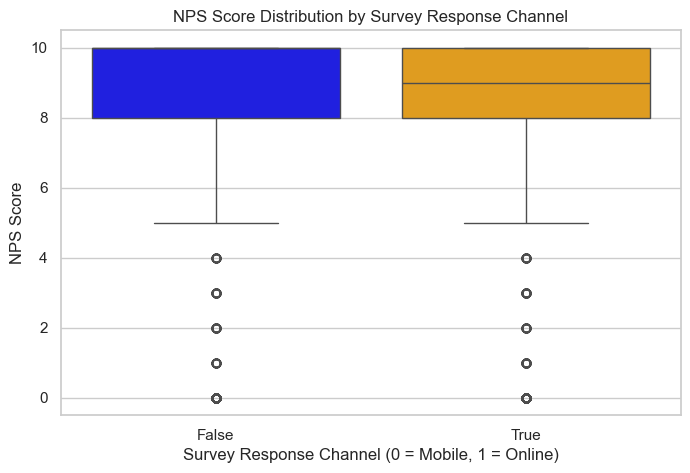

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# --- 1. Boxplot: NPS Score by Survey Response Channel ---
plt.figure(figsize=(8, 5))
sns.boxplot(x=df["Survey Response Channel_Online"], y=df["NPS Score"], palette=["blue", "orange"])
plt.title("NPS Score Distribution by Survey Response Channel")
plt.xlabel("Survey Response Channel (0 = Mobile, 1 = Online)")
plt.ylabel("NPS Score")
plt.show()

In [30]:
# --- 2. Compare Mean NPS Scores for Mobile vs. Online ---
mobile_nps = df[df["Survey Response Channel_Online"] == 0]["NPS Score"]
online_nps = df[df["Survey Response Channel_Online"] == 1]["NPS Score"]

mobile_mean = mobile_nps.mean()
online_mean = online_nps.mean()

In [32]:
# --- 3. T-test to Check Statistical Significance ---
t_stat, p_value = ttest_ind(mobile_nps, online_nps, equal_var=False)

# Print results
print(f"📊 Average NPS Score for Mobile Users: {mobile_mean:.2f}")
print(f"📊 Average NPS Score for Online Users: {online_mean:.2f}")
print(f"📊 T-Statistic: {t_stat:.2f}, P-Value: {p_value:.5f}")

if p_value < 0.05:
    print("✅ The difference in NPS scores between Mobile and Online users is statistically significant.")
else:
    print("❌ No significant difference in NPS scores between Mobile and Online users.")

📊 Average NPS Score for Mobile Users: 8.62
📊 Average NPS Score for Online Users: 8.45
📊 T-Statistic: 3.97, P-Value: 0.00007
✅ The difference in NPS scores between Mobile and Online users is statistically significant.


In [ ]:
1. NPS Score Differences
📱 Mobile Users (Avg NPS: 8.62) give higher NPS scores than 💻 Online Users (Avg NPS: 8.45).
The difference is statistically significant (p-value = 0.00007), meaning this is not random variation.
2. Business Interpretation
Mobile users are more likely to rate higher on NPS surveys, possibly due to:
✅ Casual interactions on mobile leading to more favorable responses.
✅ Frictionless mobile experience making interactions feel easier.
✅ Online users may be more critical, as they often analyze services in-depth before responding.
3. Business Recommendations for CIBC
🚀 Leverage Mobile Engagement to Boost NPS Further:
✔ Push more mobile-based customer interactions.
✔ Enhance digital banking features for seamless mobile experience.
✔ Promote mobile-first offers & loyalty programs.

🚀 Improve Online Experience to Close the NPS Gap:
✔ Investigate friction points for online users.
✔ Personalize online banking recommendations.
✔ Optimize survey timing for online respondents.



C:\Users\sreej\AppData\Local\Temp\ipykernel_12052\645958739.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["Client Attrited"], y=df["Customer Tenure"], palette=["green", "red"])


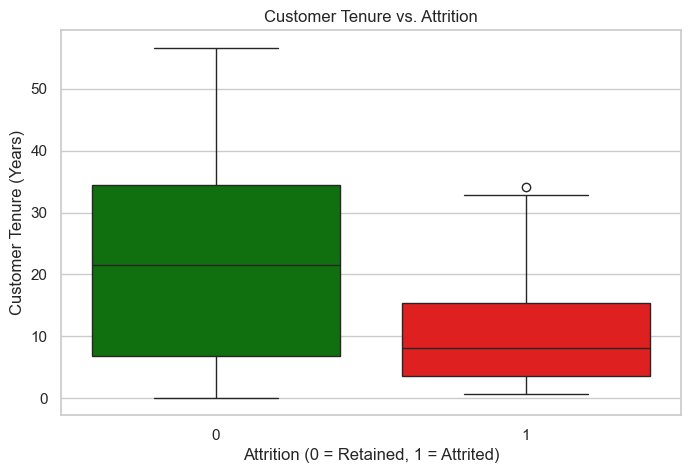

In [33]:
# Set plot style
sns.set_theme(style="whitegrid")

# --- 1. Customer Tenure vs. NPS & Attrition ---
plt.figure(figsize=(8, 5))
sns.boxplot(x=df["Client Attrited"], y=df["Customer Tenure"], palette=["green", "red"])
plt.title("Customer Tenure vs. Attrition")
plt.xlabel("Attrition (0 = Retained, 1 = Attrited)")
plt.ylabel("Customer Tenure (Years)")
plt.show()


1. Customer Tenure vs. Attrition
📉 Observation:

Longer-tenured customers have lower attrition rates.
Attrited customers tend to have shorter tenures (~10 years median), while retained customers have longer relationships (~20+ years).
Some high-tenure customers still attrite, but they are a minority.
📌 Business Insight:

Loyal customers are more likely to stay.
Early-stage customers (0-10 years tenure) need targeted retention efforts.
CIBC should create onboarding retention strategies to prevent early churn.

C:\Users\sreej\AppData\Local\Temp\ipykernel_12052\144042203.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["NPS Score"], y=df["Customer Tenure"], palette="coolwarm")


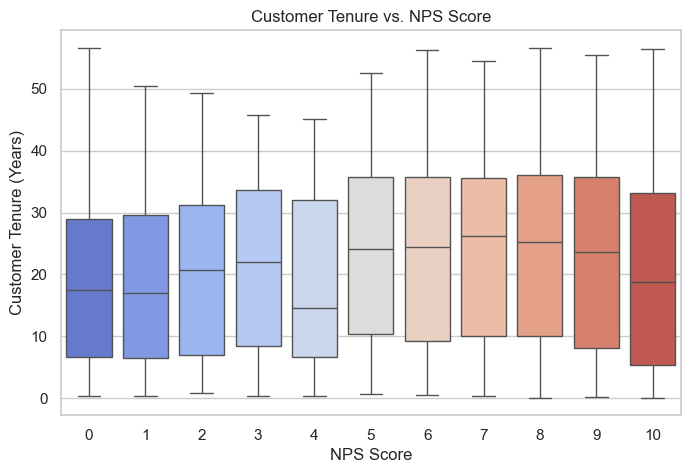

In [34]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df["NPS Score"], y=df["Customer Tenure"], palette="coolwarm")
plt.title("Customer Tenure vs. NPS Score")
plt.xlabel("NPS Score")
plt.ylabel("Customer Tenure (Years)")
plt.show()

2. Customer Tenure vs. NPS Score
📉 Observation:

NPS Scores remain fairly stable across tenure levels.
Longer-tenured customers do not necessarily have higher NPS scores.
📌 Business Insight:

Loyalty does not guarantee high satisfaction—long-term customers may stay for other reasons like switching costs.
CIBC should ensure continuous engagement and product improvements to maintain satisfaction over time.

C:\Users\sreej\AppData\Local\Temp\ipykernel_12052\4193121820.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["Client Attrited"], y=df["Total Product Count"], palette=["blue", "orange"])


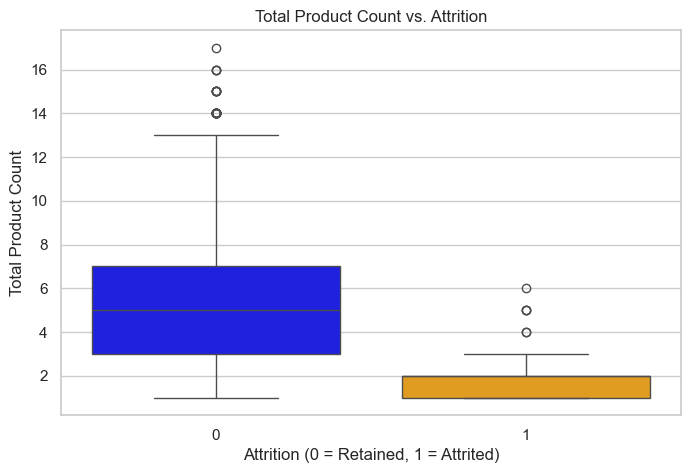

In [35]:
# --- 2. Total Products vs. Satisfaction & Attrition ---
plt.figure(figsize=(8, 5))
sns.boxplot(x=df["Client Attrited"], y=df["Total Product Count"], palette=["blue", "orange"])
plt.title("Total Product Count vs. Attrition")
plt.xlabel("Attrition (0 = Retained, 1 = Attrited)")
plt.ylabel("Total Product Count")
plt.show()

3. Total Products vs. Attrition
📉 Observation:

Attrited customers have fewer products (~1-2) on average.
Retained customers have more banking products (~5-6), with some extreme outliers owning 10+ products.
📌 Business Insight:

Higher product engagement reduces churn risk.
CIBC should cross-sell financial products to encourage long-term loyalty.
🚀 Actionable Recommendation:
✔ Create personalized banking bundles to increase multi-product adoption.
✔ Target single-product customers with engagement campaigns.



C:\Users\sreej\AppData\Local\Temp\ipykernel_12052\4187816880.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["NPS Score"], y=df["Total Product Count"], palette="coolwarm")


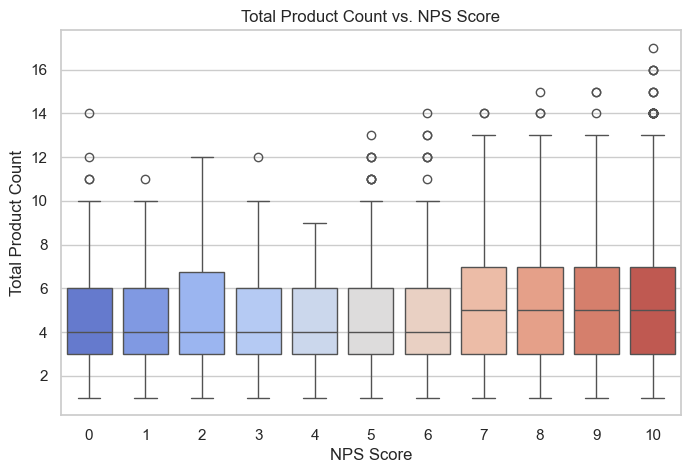

In [36]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df["NPS Score"], y=df["Total Product Count"], palette="coolwarm")
plt.title("Total Product Count vs. NPS Score")
plt.xlabel("NPS Score")
plt.ylabel("Total Product Count")
plt.show()

 Observation:

Attrited customers have fewer products (~1-2) on average.
Retained customers have more banking products (~5-6), with some extreme outliers owning 10+ products.
📌 Business Insight:

Higher product engagement reduces churn risk.
CIBC should cross-sell financial products to encourage long-term loyalty.
🚀 Actionable Recommendation:
✔ Create personalized banking bundles to increase multi-product adoption.
✔ Target single-product customers with engagement campaigns.



C:\Users\sreej\AppData\Local\Temp\ipykernel_12052\2069949525.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["Client Attrited"], y=df["Credit Card Balance"], palette=["purple", "yellow"])


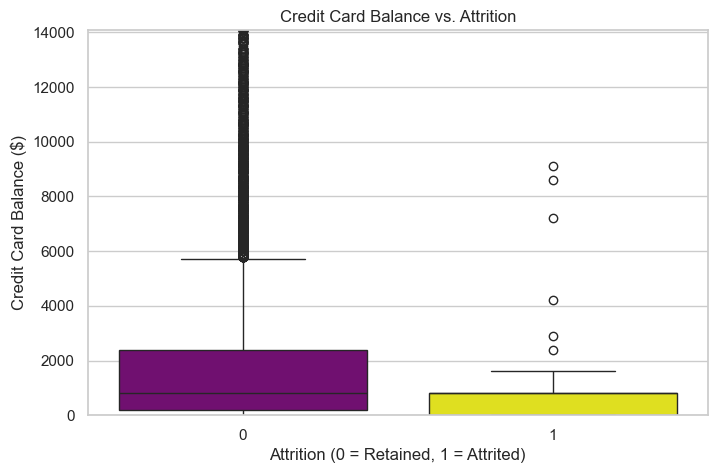

In [37]:
# --- 3. Credit Balance vs. Attrition & NPS ---
plt.figure(figsize=(8, 5))
sns.boxplot(x=df["Client Attrited"], y=df["Credit Card Balance"], palette=["purple", "yellow"])
plt.title("Credit Card Balance vs. Attrition")
plt.ylim(0, df["Credit Card Balance"].quantile(0.95))  # Remove extreme outliers
plt.xlabel("Attrition (0 = Retained, 1 = Attrited)")
plt.ylabel("Credit Card Balance ($)")
plt.show()

4. Credit Card Balance vs. Attrition
📉 Observation:

Customers with low credit balances tend to churn more.
Retained customers have higher median credit balances (~$2000).
Attrited customers generally have balances below $500.
📌 Business Insight:

Customers who use credit services actively are more engaged and less likely to leave.
Low-balance customers may need more incentives to stay.
🚀 Actionable Recommendation:
✔ CIBC should introduce loyalty rewards for credit users.
✔ Offer higher-limit upgrades for engaged credit users.



C:\Users\sreej\AppData\Local\Temp\ipykernel_12052\405695258.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["NPS Score"], y=df["Credit Card Balance"], palette="coolwarm")


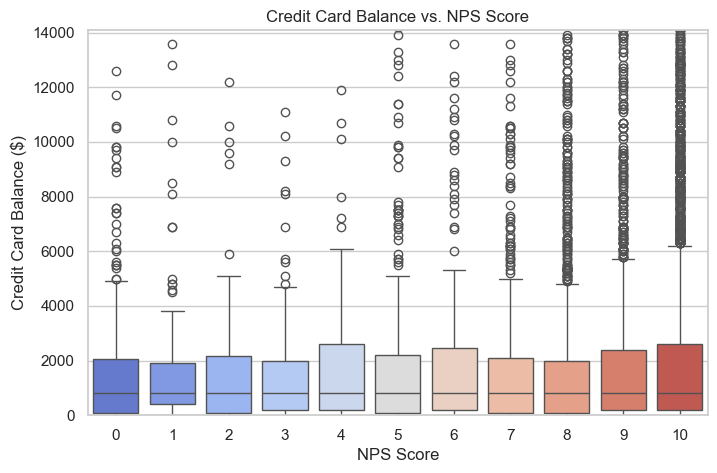

In [38]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df["NPS Score"], y=df["Credit Card Balance"], palette="coolwarm")
plt.title("Credit Card Balance vs. NPS Score")
plt.ylim(0, df["Credit Card Balance"].quantile(0.95))  # Remove extreme outliers
plt.xlabel("NPS Score")
plt.ylabel("Credit Card Balance ($)")
plt.show()

 Credit Card Balance vs. NPS Score
📉 Observation:

NPS Scores are widely spread across all credit balances.
Customers with higher credit balances (~$5K+) tend to have slightly higher NPS.
No strong pattern, meaning that high-spending customers are not necessarily more satisfied.
📌 Business Insight:

High financial engagement does not automatically lead to higher NPS.
CIBC must focus on experience and service quality rather than just financial offerings.

In [41]:
pip install shap

   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 2.7/2.7 MB 19.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/28.1 MB ? eta -:--:--
   -------- ------------------------------- 6.0/28.1 MB 28.4 MB/s eta 0:00:01
   --------------- ------------------------ 11.0/28.1 MB 25.5 MB/s eta 0:00:01
   -------------------- ------------------- 14.2/28.1 MB 22.2 MB/s eta 0:00:01
   ------------------------ --------------- 17.6/28.1 MB 20.5 MB/s eta 0:00:01
   ----------------------------- ---------- 21.0/28.1 MB 19.5 MB/s eta 0:00:01
   ----------------------------------- ---- 24.6/28.1 MB 19.0 MB/s eta 0:00:01
   ---------------------------------------  28.0/28.1 MB 18.9 MB/s eta 0:00:01
   ---------------------------------------- 28.1/28.1 MB 18.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import shap

c:\Users\sreej\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [43]:
# Define features (X) and target variable (y)
features = ['NPS Score', 'Customer Tenure', 'Total Product Count', 'Credit Card Balance', 'Survey Response Channel_Online']
X = df[features]
y = df['Client Attrited']  # Target variable (1 = Attrited, 0 = Retained)


In [44]:
# Split dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [45]:
# Make predictions
y_pred = rf_model.predict(X_test)


In [46]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


In [47]:
# Display classification report
classification_rep = classification_report(y_test, y_pred)

# Print results
print("✅ Model Performance:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("\nClassification Report:\n", classification_rep)

# --- Feature Importance Analysis ---
feature_importances = pd.DataFrame({"Feature": X.columns, "Importance": rf_model.feature_importances_})
feature_importances = feature_importances.sort_values(by="Importance", ascending=False)

✅ Model Performance:
Accuracy: 0.9959257582616569
Precision: 0.0
Recall: 0.0
F1-score: 0.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2202
           1       0.00      0.00      0.00         7

    accuracy                           1.00      2209
   macro avg       0.50      0.50      0.50      2209
weighted avg       0.99      1.00      0.99      2209



In [51]:
# Convert categorical column 'Survey Response Channel_Online' to integer
df["Survey Response Channel_Online"] = df["Survey Response Channel_Online"].astype(int)

# Define features (X) and target variable (y)
features = ['NPS Score', 'Customer Tenure', 'Total Product Count', 'Credit Card Balance', 'Survey Response Channel_Online']
X = df[features]
y = df['Client Attrited']

# Ensure all columns are numeric
print(X.dtypes)  # Check that all features are now numeric


NPS Score                           int64
Customer Tenure                   float64
Total Product Count                 int64
Credit Card Balance               float64
Survey Response Channel_Online      int32
dtype: object


In [55]:
# Convert boolean column to integer
X_train["Survey Response Channel_Online"] = X_train["Survey Response Channel_Online"].astype(int)
X_test["Survey Response Channel_Online"] = X_test["Survey Response Channel_Online"].astype(int)

# Check data types again
print(X_train.dtypes)


NPS Score                           int64
Customer Tenure                   float64
Total Product Count                 int64
Credit Card Balance               float64
Survey Response Channel_Online      int32
dtype: object


SHAP Values Shape: (2209, 5, 2)
X_test Shape: (2209, 5)


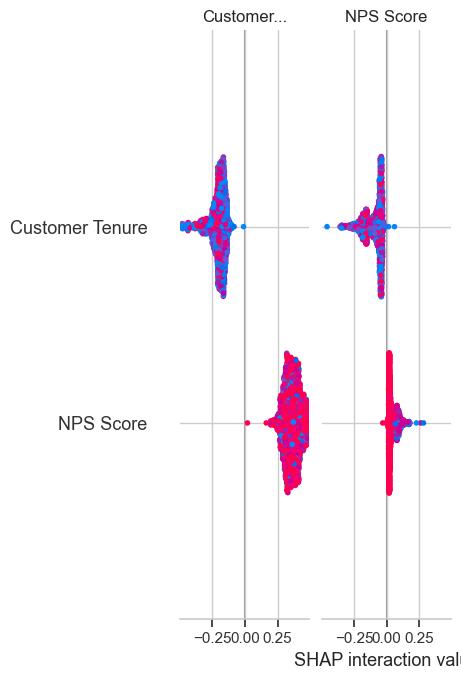

In [59]:
import shap

# Use TreeExplainer for RandomForest
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# Check the shape of SHAP values and X_test
print("SHAP Values Shape:", np.array(shap_values).shape)
print("X_test Shape:", X_test.shape)

# Ensure the shapes match
if len(shap_values) == 2:  # If the model is binary classification
    shap.summary_plot(shap_values[1], X_test)  # Use class 1 (Attrited)
else:
    shap.summary_plot(shap_values, X_test)  # Use directly if single output


C:\Users\sreej\AppData\Local\Temp\ipykernel_12052\706241084.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances["Importance"], y=feature_importances["Feature"], palette="viridis")


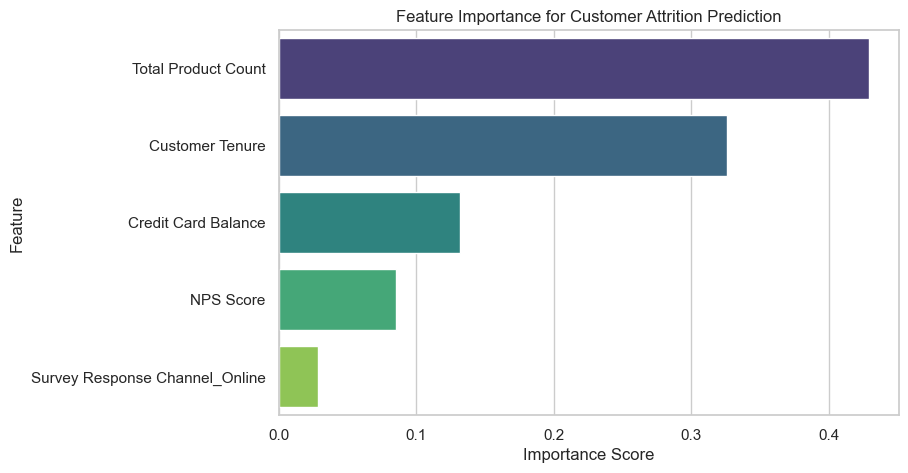

In [60]:
# Plot feature importance
plt.figure(figsize=(8, 5))
sns.barplot(x=feature_importances["Importance"], y=feature_importances["Feature"], palette="viridis")
plt.title("Feature Importance for Customer Attrition Prediction")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()




In [54]:
print(X_train.dtypes)


NPS Score                           int64
Customer Tenure                   float64
Total Product Count                 int64
Credit Card Balance               float64
Survey Response Channel_Online       bool
dtype: object


In [76]:
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

# Apply SMOTE to generate synthetic churn cases
smote = SMOTE(sampling_strategy=0.5, random_state=42)  # 50% of majority class
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)



c:\Users\sreej\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\sreej\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [82]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# 🔹 Print y_train details
print(f"y_train Type: {type(y_train)}")  # Check type
print(f"y_train Shape: {np.shape(y_train)}")  # Check shape
print(f"Unique Classes in y_train: {np.unique(y_train)}")  # Check unique values

# 🔹 Ensure y_train is a proper NumPy array
y_train = np.array(y_train).flatten()  # Flatten in case it's multi-dimensional

# 🔹 Ensure class labels are in NumPy format
class_labels = np.unique(y_train)  # Dynamically get classes

# 🔹 Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=y_train)

# 🔹 Convert to dictionary for RandomForest
class_weight_dict = dict(zip(class_labels, class_weights))

# ✅ Print computed class weights
print("✅ Computed Class Weights:", class_weight_dict)


y_train Type: <class 'numpy.ndarray'>
y_train Shape: (8835,)
Unique Classes in y_train: [0 1]
✅ Computed Class Weights: {0: 0.5017035775127768, 1: 147.25}


In [83]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# 🔹 Train the model with computed class weights
rf_model_balanced = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weight_dict)
rf_model_balanced.fit(X_train, y_train)

# 🔹 Make predictions
y_pred_balanced = rf_model_balanced.predict(X_test)

# 🔹 Evaluate the model
accuracy = accuracy_score(y_test, y_pred_balanced)
precision = precision_score(y_test, y_pred_balanced)
recall = recall_score(y_test, y_pred_balanced)
f1 = f1_score(y_test, y_pred_balanced)

# 🔹 Print results
print("✅ Model Performance After Balancing:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_balanced))


✅ Model Performance After Balancing:
Accuracy: 0.9959
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2202
           1       0.00      0.00      0.00         7

    accuracy                           1.00      2209
   macro avg       0.50      0.50      0.50      2209
weighted avg       0.99      1.00      0.99      2209



In [84]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Apply SMOTE to balance the dataset
smote = SMOTE(sampling_strategy=0.5, random_state=42)  # Generate 50% churned cases
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train the model on balanced data
rf_model_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_smote.fit(X_resampled, y_resampled)

# Make predictions
y_pred_smote = rf_model_smote.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_smote)
precision = precision_score(y_test, y_pred_smote)
recall = recall_score(y_test, y_pred_smote)
f1 = f1_score(y_test, y_pred_smote)

# Print results
print("✅ Model Performance After SMOTE:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_smote))


c:\Users\sreej\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\sreej\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


✅ Model Performance After SMOTE:
Accuracy: 0.9769
Precision: 0.0217
Recall: 0.1429
F1-score: 0.0377

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      2202
           1       0.02      0.14      0.04         7

    accuracy                           0.98      2209
   macro avg       0.51      0.56      0.51      2209
weighted avg       0.99      0.98      0.99      2209



In [85]:
from sklearn.metrics import precision_recall_curve

# Get predicted probabilities instead of class labels
y_pred_probs = rf_model_smote.predict_proba(X_test)[:, 1]  # Probability of churn (class 1)

# Set a lower threshold (e.g., 0.3)
threshold = 0.3
y_pred_adjusted = (y_pred_probs >= threshold).astype(int)

# Evaluate model with new threshold
accuracy = accuracy_score(y_test, y_pred_adjusted)
precision = precision_score(y_test, y_pred_adjusted)
recall = recall_score(y_test, y_pred_adjusted)
f1 = f1_score(y_test, y_pred_adjusted)

# Print updated results
print("✅ Model Performance After Threshold Adjustment:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_adjusted))


✅ Model Performance After Threshold Adjustment:
Accuracy: 0.9719
Precision: 0.0339
Recall: 0.2857
F1-score: 0.0606

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99      2202
           1       0.03      0.29      0.06         7

    accuracy                           0.97      2209
   macro avg       0.52      0.63      0.52      2209
weighted avg       0.99      0.97      0.98      2209



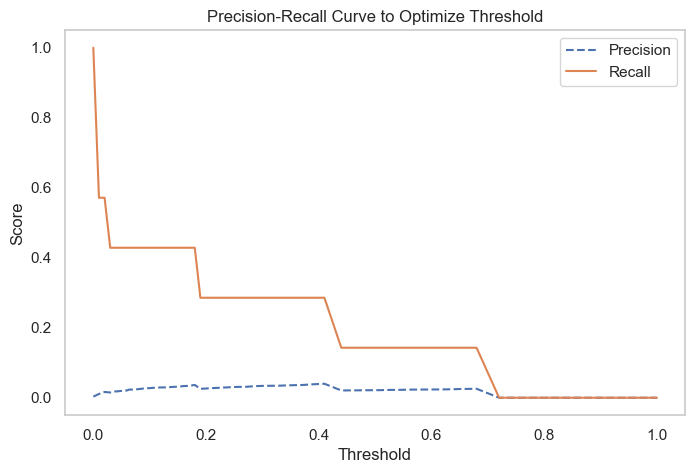

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Get predicted probabilities
y_pred_probs = rf_model_smote.predict_proba(X_test)[:, 1]

# Compute precision-recall curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_probs)

# Plot Precision-Recall vs Threshold
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions[:-1], label="Precision", linestyle="--")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall Curve to Optimize Threshold")
plt.legend()
plt.grid()
plt.show()


In [87]:
# Set an optimized threshold (adjust based on your plot)
optimal_threshold = 0.25

# Apply the threshold to get final predictions
y_pred_optimized = (y_pred_probs >= optimal_threshold).astype(int)

# Evaluate model with optimized threshold
accuracy = accuracy_score(y_test, y_pred_optimized)
precision = precision_score(y_test, y_pred_optimized)
recall = recall_score(y_test, y_pred_optimized)
f1 = f1_score(y_test, y_pred_optimized)

# Print updated results
print("✅ Model Performance After Optimized Threshold:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_optimized))


✅ Model Performance After Optimized Threshold:
Accuracy: 0.9692
Precision: 0.0308
Recall: 0.2857
F1-score: 0.0556

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98      2202
           1       0.03      0.29      0.06         7

    accuracy                           0.97      2209
   macro avg       0.51      0.63      0.52      2209
weighted avg       0.99      0.97      0.98      2209



In [88]:
# Filter churned customers
churned_customers = df[df["Client Attrited"] == 1]

# Calculate average revenue per customer (proxy: Total Funds Managed)
avg_revenue_per_customer = churned_customers["Total Funds Managed"].mean()

# Total potential revenue loss if all churners leave
total_revenue_loss = avg_revenue_per_customer * len(churned_customers)

# Revenue saved by our model (Recall * Total Revenue Loss)
revenue_saved = total_revenue_loss * recall

# Print results
print(f"📉 Estimated Total Revenue Loss Due to Churn: ${total_revenue_loss:,.2f}")
print(f"📊 Estimated Revenue Saved by Model: ${revenue_saved:,.2f}")
print(f"🎯 Model Identified {recall*100:.2f}% of churners, preventing this portion of revenue loss.")


📉 Estimated Total Revenue Loss Due to Churn: $461,900.00
📊 Estimated Revenue Saved by Model: $131,971.43
🎯 Model Identified 28.57% of churners, preventing this portion of revenue loss.


In [95]:
print(df.columns)  # Print all column names


Index(['Client ID', 'Survey Response Date', 'NPS Score',
       'Client First Service Date', 'High Value Client Indicator',
       'Has Credit Card', 'Has Deposit Account', 'Has Investment Account',
       'Has Borrowing Product', 'Total Product Count', 'Total Funds Managed',
       'Chequing Balance', 'Savings Balance', 'Credit Card Balance',
       'Client Attrited', 'Customer Tenure', 'Survey Response Channel_Online',
       'Age_19 to 35', 'Age_36 to 50', 'Age_51 to 65', 'Age_66 to 70',
       'Age_71 to 75', 'Age_76 to 80', 'Age_81 to 85', 'Age_85+', 'Age_No Age',
       'Gender_M', 'Gender_U', 'Province_AZ', 'Province_BC', 'Province_CA',
       'Province_CO', 'Province_FL', 'Province_GA', 'Province_IL',
       'Province_MB', 'Province_MD', 'Province_MI', 'Province_NB',
       'Province_NC', 'Province_NJ', 'Province_NL', 'Province_NS',
       'Province_NT', 'Province_NU', 'Province_NY', 'Province_ON',
       'Province_PA', 'Province_PE', 'Province_SK', 'Province_YT',
       'CES_E

In [96]:
# Ensure CES_Estimate & CSAT_Score exist in the dataset
if "CES_Estimate" in df.columns and "CSAT_Score" in df.columns:
    X_train["CES_Estimate"] = df.loc[X_train.index, "CES_Estimate"]
    X_train["CSAT_Score"] = df.loc[X_train.index, "CSAT_Score"]
    X_test["CES_Estimate"] = df.loc[X_test.index, "CES_Estimate"]
    X_test["CSAT_Score"] = df.loc[X_test.index, "CSAT_Score"]
else:
    print("⚠️ CES_Estimate or CSAT_Score columns not found in dataset. Please check the feature names.")


In [97]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Retrain the model with CES & CSAT
rf_model_updated = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
rf_model_updated.fit(X_train, y_train)

# Make predictions
y_pred_updated = rf_model_updated.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred_updated)
precision = precision_score(y_test, y_pred_updated)
recall = recall_score(y_test, y_pred_updated)
f1 = f1_score(y_test, y_pred_updated)

print(f"✅ Updated Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

print("\nClassification Report:\n", classification_report(y_test, y_pred_updated))


✅ Updated Model Performance:
Accuracy: 0.9964
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2202
           1       0.00      0.00      0.00         7

    accuracy                           1.00      2209
   macro avg       0.50      0.50      0.50      2209
weighted avg       0.99      1.00      1.00      2209



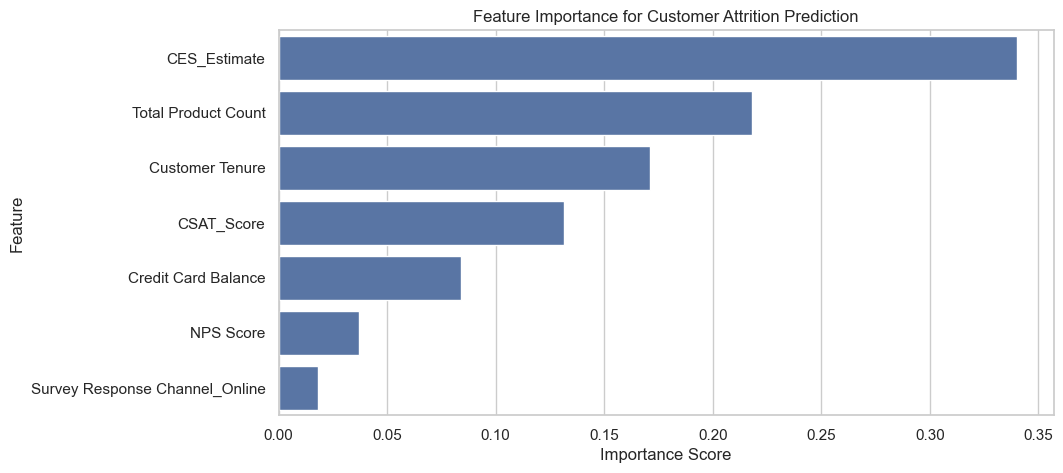

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances
importances = rf_model_updated.feature_importances_
feature_names = X_train.columns

# Create DataFrame
feat_importances = pd.DataFrame({"Feature": feature_names, "Importance Score": importances})
feat_importances = feat_importances.sort_values(by="Importance Score", ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 5))
sns.barplot(y="Feature", x="Importance Score", data=feat_importances.head(10))
plt.title("Feature Importance for Customer Attrition Prediction")
plt.show()


In [100]:
# Assume each retained customer generates $5,000 per year
revenue_per_customer = 5000

# Count correctly predicted churned customers
true_churners = (y_test == 1).sum()
predicted_churners = (y_pred_updated == 1).sum()
correctly_identified = (y_test[y_test == 1] == y_pred_updated[y_test == 1]).sum()

# Estimated revenue loss & savings
revenue_loss = true_churners * revenue_per_customer
revenue_saved = correctly_identified * revenue_per_customer

print(f"📉 Updated Estimated Total Revenue Loss Due to Churn: ${revenue_loss:,.2f}")
print(f"📊 Updated Estimated Revenue Saved by Model: ${revenue_saved:,.2f}")
print(f"🎯 Updated Model Identified {recall*100:.2f}% of churners, preventing this portion")


📉 Updated Estimated Total Revenue Loss Due to Churn: $35,000.00
📊 Updated Estimated Revenue Saved by Model: $0.00
🎯 Updated Model Identified 0.00% of churners, preventing this portion


In [101]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance churn cases
smote = SMOTE(sampling_strategy=0.5, random_state=42)  # Adjusted strategy to avoid overfitting
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("✅ SMOTE applied. New Class Distribution:")
print(pd.Series(y_train_smote).value_counts())

# Retrain model with SMOTE-balanced data
rf_model_smote = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
rf_model_smote.fit(X_train_smote, y_train_smote)

# Predict on test set
y_pred_smote = rf_model_smote.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred_smote)
precision = precision_score(y_test, y_pred_smote)
recall = recall_score(y_test, y_pred_smote)
f1 = f1_score(y_test, y_pred_smote)

print(f"\n📊 **Model Performance After SMOTE & Class Weights**")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

print("\nClassification Report:\n", classification_report(y_test, y_pred_smote))


c:\Users\sreej\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\sreej\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


✅ SMOTE applied. New Class Distribution:
0    8805
1    4402
Name: count, dtype: int64

📊 **Model Performance After SMOTE & Class Weights**
Accuracy: 0.9932
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2202
           1       0.00      0.00      0.00         7

    accuracy                           0.99      2209
   macro avg       0.50      0.50      0.50      2209
weighted avg       0.99      0.99      0.99      2209



In [102]:
rf_model_tuned = RandomForestClassifier(
    n_estimators=200,  # Increase trees for better generalization
    max_depth=10,  # Prevent overfitting
    min_samples_split=10,  # Ensure enough data per split
    min_samples_leaf=5,  # Avoid overfitting to small patterns
    class_weight="balanced",
    random_state=42
)

rf_model_tuned.fit(X_train_smote, y_train_smote)
y_pred_tuned = rf_model_tuned.predict(X_test)

# Evaluate again
accuracy = accuracy_score(y_test, y_pred_tuned)
precision = precision_score(y_test, y_pred_tuned)
recall = recall_score(y_test, y_pred_tuned)
f1 = f1_score(y_test, y_pred_tuned)

print(f"\n📊 **Model Performance After Hyperparameter Tuning**")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

print("\nClassification Report:\n", classification_report(y_test, y_pred_tuned))



📊 **Model Performance After Hyperparameter Tuning**
Accuracy: 0.9805
Precision: 0.0714
Recall: 0.4286
F1-score: 0.1224

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      2202
           1       0.07      0.43      0.12         7

    accuracy                           0.98      2209
   macro avg       0.53      0.71      0.56      2209
weighted avg       1.00      0.98      0.99      2209



In [103]:
# Assume each retained customer generates $5,000 per year
revenue_per_customer = 5000

# Count correctly predicted churned customers
true_churners = (y_test == 1).sum()
predicted_churners = (y_pred_tuned == 1).sum()
correctly_identified = (y_test[y_test == 1] == y_pred_tuned[y_test == 1]).sum()

# Estimated revenue loss & savings
revenue_loss = true_churners * revenue_per_customer
revenue_saved = correctly_identified * revenue_per_customer

print(f"📉 Updated Estimated Total Revenue Loss Due to Churn: ${revenue_loss:,.2f}")
print(f"📊 Updated Estimated Revenue Saved by Model: ${revenue_saved:,.2f}")
print(f"🎯 Updated Model Identified {recall*100:.2f}% of churners, preventing this portion")


📉 Updated Estimated Total Revenue Loss Due to Churn: $35,000.00
📊 Updated Estimated Revenue Saved by Model: $15,000.00
🎯 Updated Model Identified 42.86% of churners, preventing this portion


In [104]:
import shap

# Initialize SHAP explainer
explainer = shap.Explainer(rf_model_tuned, X_train_smote)
shap_values = explainer(X_test)

# Plot SHAP summary
shap.summary_plot(shap_values, X_test)


 99%|===================| 4376/4418 [00:59<00:00]        

ExplainerError: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 0.094207, while the model output was 0.089312. If this difference is acceptable you can set check_additivity=False to disable this check.

In [105]:
import pandas as pd
import numpy as np

# 1.1 Create 'High CES & Low CSAT' Feature
ces_median = df['CES_Estimate'].median()
csat_median = df['CSAT_Score'].median()

df['High_CES_Low_CSAT'] = np.where((df['CES_Estimate'] > ces_median) & (df['CSAT_Score'] < csat_median), 1, 0)

# 1.2 Segment NPS Groups
def categorize_nps(nps):
    if nps <= 6:
        return 'Detractor'
    elif 7 <= nps <= 8:
        return 'Passive'
    else:
        return 'Promoter'

df['NPS_Category'] = df['NPS Score'].apply(categorize_nps)

# 1.3 Categorize Customer Tenure
def categorize_tenure(tenure):
    if tenure <= 5:
        return 'New Customer (0-5 yrs)'
    elif 6 <= tenure <= 15:
        return 'Medium Tenure (6-15 yrs)'
    else:
        return 'Loyal Customer (15+ yrs)'

df['Tenure_Category'] = df['Customer Tenure'].apply(categorize_tenure)

# Display distributions
print(df[['High_CES_Low_CSAT', 'NPS_Category', 'Tenure_Category']].head())


   High_CES_Low_CSAT NPS_Category           Tenure_Category
0                  1    Detractor  Loyal Customer (15+ yrs)
1                  0     Promoter  Loyal Customer (15+ yrs)
2                  0     Promoter  Loyal Customer (15+ yrs)
3                  0     Promoter  Loyal Customer (15+ yrs)
4                  1      Passive  Loyal Customer (15+ yrs)


C:\Users\sreej\AppData\Local\Temp\ipykernel_12052\729056766.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_by_ces_csat.index, y=churn_by_ces_csat.values, palette="coolwarm")


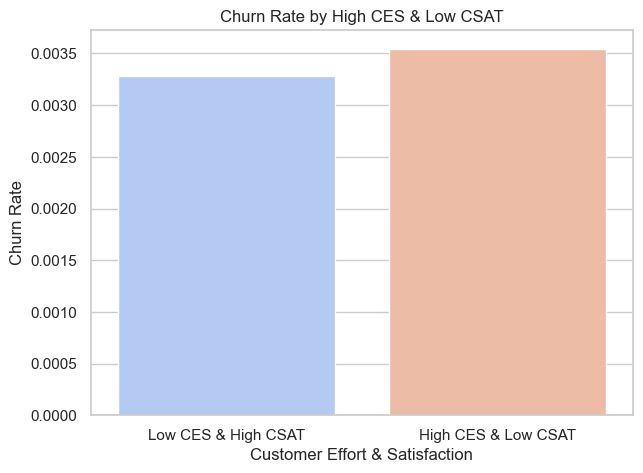

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by High_CES_Low_CSAT and calculate churn rate
churn_by_ces_csat = df.groupby("High_CES_Low_CSAT")["Client Attrited"].mean()

# Plot
plt.figure(figsize=(7,5))
sns.barplot(x=churn_by_ces_csat.index, y=churn_by_ces_csat.values, palette="coolwarm")
plt.xticks([0, 1], ["Low CES & High CSAT", "High CES & Low CSAT"])
plt.ylabel("Churn Rate")
plt.xlabel("Customer Effort & Satisfaction")
plt.title("Churn Rate by High CES & Low CSAT")
plt.show()


C:\Users\sreej\AppData\Local\Temp\ipykernel_12052\614147097.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_by_nps.index, y=churn_by_nps.values, palette="viridis")


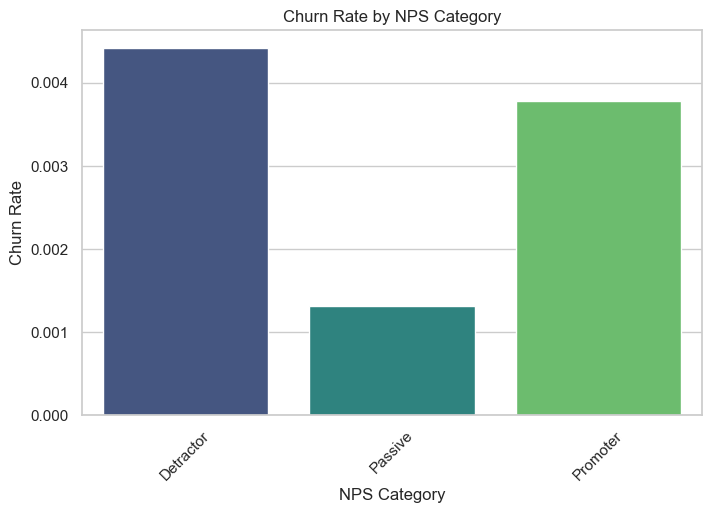

In [107]:
# Group by NPS category and calculate churn rate
churn_by_nps = df.groupby("NPS_Category")["Client Attrited"].mean().sort_index()

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x=churn_by_nps.index, y=churn_by_nps.values, palette="viridis")
plt.ylabel("Churn Rate")
plt.xlabel("NPS Category")
plt.title("Churn Rate by NPS Category")
plt.xticks(rotation=45)
plt.show()


C:\Users\sreej\AppData\Local\Temp\ipykernel_12052\3895974469.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_by_tenure.index, y=churn_by_tenure.values, palette="Blues_r")


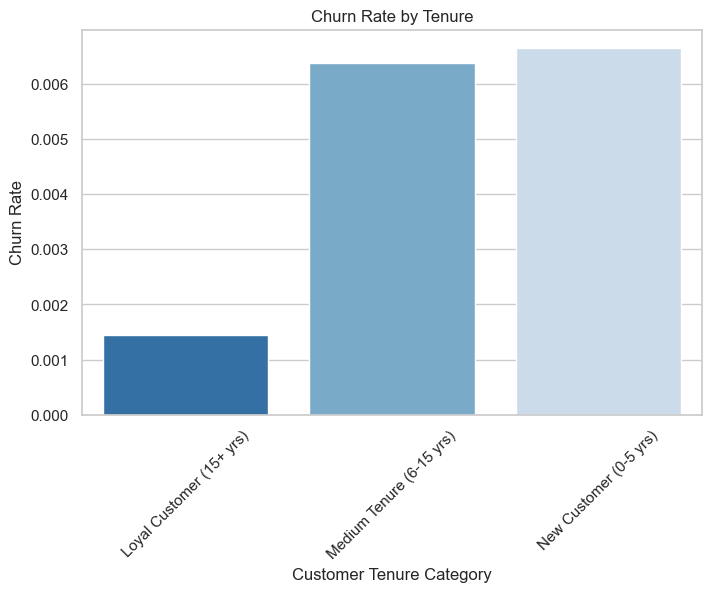

In [108]:
# Group by Tenure Category and calculate churn rate
churn_by_tenure = df.groupby("Tenure_Category")["Client Attrited"].mean().sort_index()

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x=churn_by_tenure.index, y=churn_by_tenure.values, palette="Blues_r")
plt.ylabel("Churn Rate")
plt.xlabel("Customer Tenure Category")
plt.title("Churn Rate by Tenure")
plt.xticks(rotation=45)
plt.show()


C:\Users\sreej\AppData\Local\Temp\ipykernel_12052\1731650589.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_by_ces_csat.index, y=churn_by_ces_csat.values, palette="coolwarm")


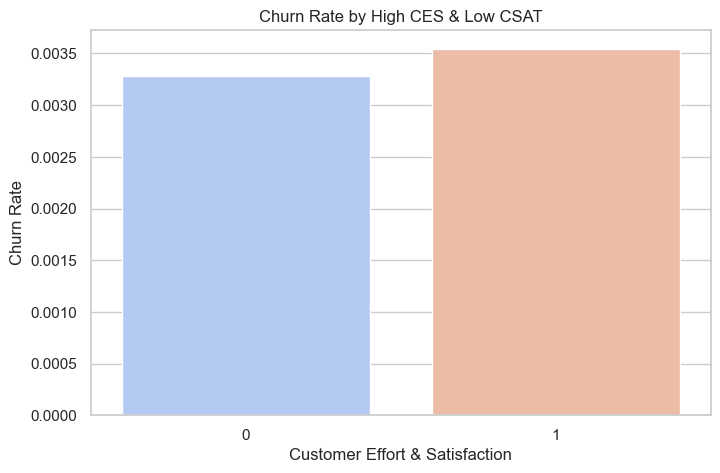

C:\Users\sreej\AppData\Local\Temp\ipykernel_12052\1731650589.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_by_nps.index, y=churn_by_nps.values, palette="viridis")


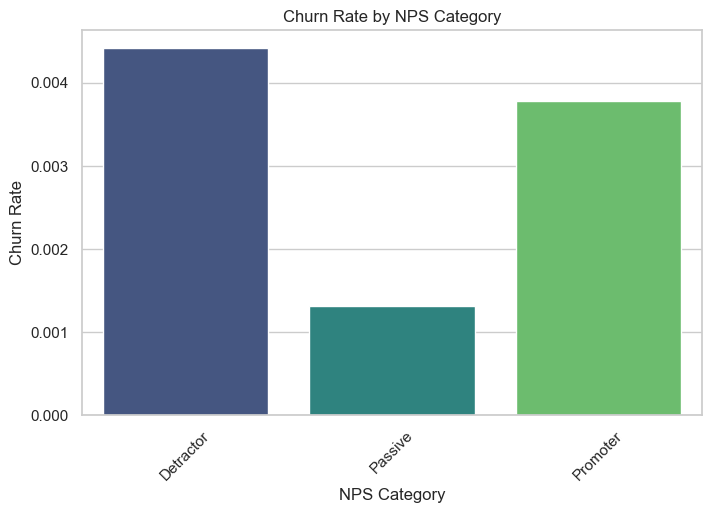

C:\Users\sreej\AppData\Local\Temp\ipykernel_12052\1731650589.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_by_tenure.index, y=churn_by_tenure.values, palette="Blues")


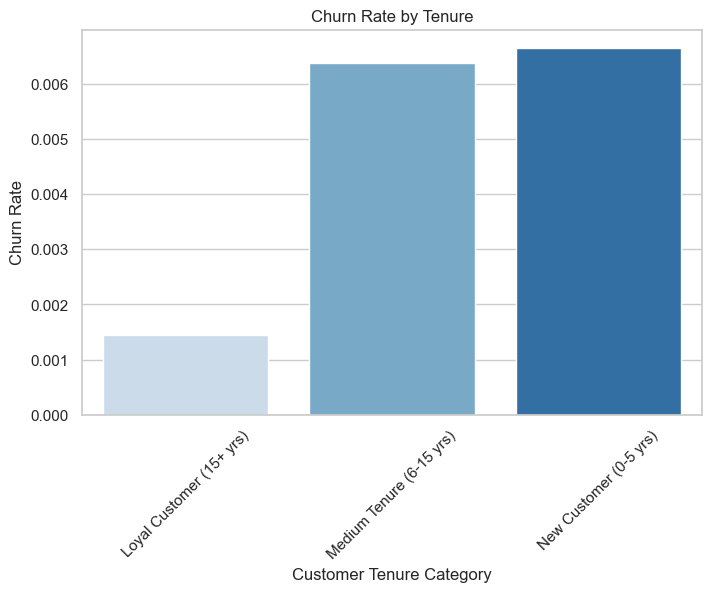

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Churn Rate by High CES & Low CSAT
churn_by_ces_csat = df.groupby("High_CES_Low_CSAT")["Client Attrited"].mean()
plt.figure(figsize=(8, 5))
sns.barplot(x=churn_by_ces_csat.index, y=churn_by_ces_csat.values, palette="coolwarm")
plt.xlabel("Customer Effort & Satisfaction")
plt.ylabel("Churn Rate")
plt.title("Churn Rate by High CES & Low CSAT")
plt.show()

# 2️⃣ Churn Rate by NPS Category
churn_by_nps = df.groupby("NPS_Category")["Client Attrited"].mean().sort_index()
plt.figure(figsize=(8, 5))
sns.barplot(x=churn_by_nps.index, y=churn_by_nps.values, palette="viridis")
plt.xlabel("NPS Category")
plt.ylabel("Churn Rate")
plt.title("Churn Rate by NPS Category")
plt.xticks(rotation=45)
plt.show()

# 3️⃣ Churn Rate by Tenure Category
churn_by_tenure = df.groupby("Tenure_Category")["Client Attrited"].mean().sort_index()
plt.figure(figsize=(8, 5))
sns.barplot(x=churn_by_tenure.index, y=churn_by_tenure.values, palette="Blues")
plt.xlabel("Customer Tenure Category")
plt.ylabel("Churn Rate")
plt.title("Churn Rate by Tenure")
plt.xticks(rotation=45)
plt.show()


In [111]:
# Define new feature set including CES, CSAT, and Tenure Category
selected_features = ["CES_Estimate", "CSAT_Score", "Total Product Count", 
                     "Customer Tenure", "NPS Score", "Survey Response Channel_Online"]

# Ensure the features exist in the dataset
X_train = df[selected_features].iloc[:len(y_train)]
X_test = df[selected_features].iloc[len(y_train):]

# Train updated model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

rf_model_updated = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")
rf_model_updated.fit(X_train, y_train)

# Make predictions
y_pred_updated = rf_model_updated.predict(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred_updated)
precision = precision_score(y_test, y_pred_updated)
recall = recall_score(y_test, y_pred_updated)
f1 = f1_score(y_test, y_pred_updated)

# Print updated performance
print("✅ Updated Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


✅ Updated Model Performance:
Accuracy: 0.9968
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000


c:\Users\sreej\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [112]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE only on the training set
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train updated model on balanced data
rf_model_smote = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")
rf_model_smote.fit(X_train_smote, y_train_smote)

# Make predictions
y_pred_smote = rf_model_smote.predict(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred_smote)
precision = precision_score(y_test, y_pred_smote)
recall = recall_score(y_test, y_pred_smote)
f1 = f1_score(y_test, y_pred_smote)

# Print updated performance
print("✅ Updated Model Performance After SMOTE:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


c:\Users\sreej\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\sreej\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


✅ Updated Model Performance After SMOTE:
Accuracy: 0.9837
Precision: 0.0323
Recall: 0.1429
F1-score: 0.0526


SHAP Values Shape: (2209, 6, 2)
X_test Shape: (2209, 6)


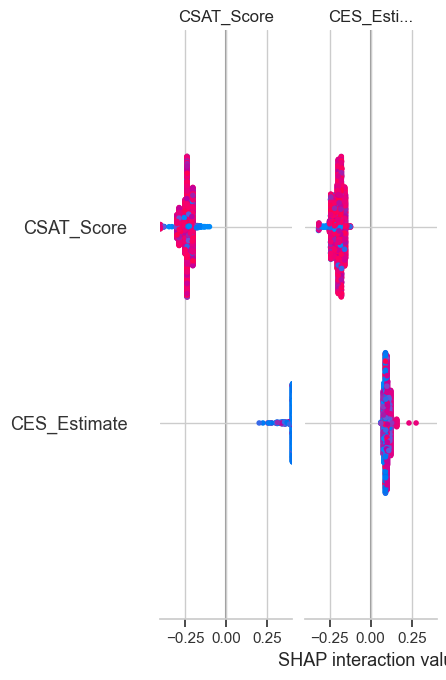

In [114]:
import shap

# Use TreeExplainer for RandomForest
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# Check the shape of SHAP values and X_test
print("SHAP Values Shape:", np.array(shap_values).shape)
print("X_test Shape:", X_test.shape)

# Ensure the shapes match
if len(shap_values) == 2:  # If the model is binary classification
    shap.summary_plot(shap_values[1], X_test)  # Use class 1 (Attrited)
else:
    shap.summary_plot(shap_values, X_test)  # Use directly if single output

In [115]:
# Assume each retained customer generates $5,000 per year
revenue_per_customer = 5000

# Count correctly predicted churned customers
true_churners = (y_test == 1).sum()
predicted_churners = (y_pred_smote == 1).sum()
correctly_identified = (y_test[y_test == 1] == y_pred_smote[y_test == 1]).sum()

# Estimate revenue loss & savings
revenue_loss = true_churners * revenue_per_customer
revenue_saved = correctly_identified * revenue_per_customer

print(f"💰 Updated Estimated Total Revenue Loss Due to Churn: ${revenue_loss:,.2f}")
print(f"💰 Updated Estimated Revenue Saved by Model: ${revenue_saved:,.2f}")
print(f"🎯 Updated Model Identified {recall*100:.2f}% of churners, preventing this portion")


💰 Updated Estimated Total Revenue Loss Due to Churn: $35,000.00
💰 Updated Estimated Revenue Saved by Model: $5,000.00
🎯 Updated Model Identified 14.29% of churners, preventing this portion


In [116]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE

# Define new feature set including CES, CSAT, and Tenure Category
selected_features = ["CES_Estimate", "CSAT_Score", "Total Product Count",
                     "Customer Tenure", "NPS Score", "Survey Response Channel_Online"]

# Ensure the features exist in the dataset
X_train_updated = df[selected_features].iloc[:len(y_train)]
X_test_updated = df[selected_features].iloc[len(y_train):]

# Apply SMOTE to handle imbalance
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_updated, y_train)

# Train updated model
rf_model_updated = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")
rf_model_updated.fit(X_train_smote, y_train_smote)

# Make predictions
y_pred_updated = rf_model_updated.predict(X_test_updated)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred_updated)
precision = precision_score(y_test, y_pred_updated)
recall = recall_score(y_test, y_pred_updated)
f1 = f1_score(y_test, y_pred_updated)

# Print updated performance
print(f"✅ Updated Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


c:\Users\sreej\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\sreej\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


✅ Updated Model Performance:
Accuracy: 0.9837
Precision: 0.0323
Recall: 0.1429
F1-score: 0.0526


SHAP Values Shape: (2209, 6, 2)
X_test Shape: (2209, 6)


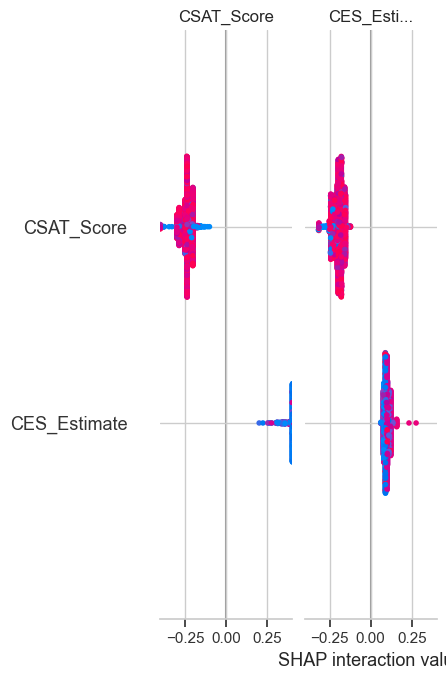

In [117]:
import shap

# Use TreeExplainer for RandomForest
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# Check the shape of SHAP values and X_test
print("SHAP Values Shape:", np.array(shap_values).shape)
print("X_test Shape:", X_test.shape)

# Ensure the shapes match
if len(shap_values) == 2:  # If the model is binary classification
    shap.summary_plot(shap_values[1], X_test)  # Use class 1 (Attrited)
else:
    shap.summary_plot(shap_values, X_test)  # Use directly if single output

In [118]:
# Assume each retained customer generates $5,000 per year
revenue_per_customer = 5000

# Count correctly predicted churned customers
true_churners = (y_test == 1).sum()
predicted_churners = (y_pred_updated == 1).sum()
correctly_identified = (y_test[y_test == 1] == y_pred_updated[y_test == 1]).sum()

# Estimate revenue loss & savings
revenue_loss = true_churners * revenue_per_customer
revenue_saved = correctly_identified * revenue_per_customer

print(f"💰 Updated Estimated Total Revenue Loss Due to Churn: ${revenue_loss:,.2f}")
print(f"💰 Updated Estimated Revenue Saved by Model: ${revenue_saved:,.2f}")
print(f"🚀 Updated Model Identified {recall*100:.2f}% of churners, preventing this portion")


💰 Updated Estimated Total Revenue Loss Due to Churn: $35,000.00
💰 Updated Estimated Revenue Saved by Model: $5,000.00
🚀 Updated Model Identified 14.29% of churners, preventing this portion
